In [53]:
#IMPORTING NECESSARY LIBRARIES
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
import warnings
from sklearn.exceptions import ConvergenceWarning
import pickle
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error , mean_squared_error
warnings.filterwarnings("ignore", category=ConvergenceWarning) 


In [36]:
df = pd.read_csv('train.csv')

In [37]:
#Get info about dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [38]:
#Check how many nulls are there for each feature 
df.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [39]:
# Handle this null values and replace them for mode or mean according to the type of the feature 
df['Gender'].fillna(df['Gender'].mode()[0],inplace=True)
df['Married'].fillna(df['Married'].mode()[0],inplace=True)
df['Dependents'].fillna(df['Dependents'].mode()[0],inplace=True)
df['Self_Employed'].fillna(df['Self_Employed'].mode()[0],inplace=True)
df['LoanAmount'] =df['LoanAmount'].fillna(df['LoanAmount'].mean())
df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].mode()[0],inplace=True)
df['Credit_History'].fillna(df['Credit_History'].mode()[0],inplace=True)

df.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

In [40]:
# Dividing columns into categorical and numerical in order to get better data analysis
categorical_columns = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area','Credit_History','Loan_Amount_Term']

numerical_columns = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']


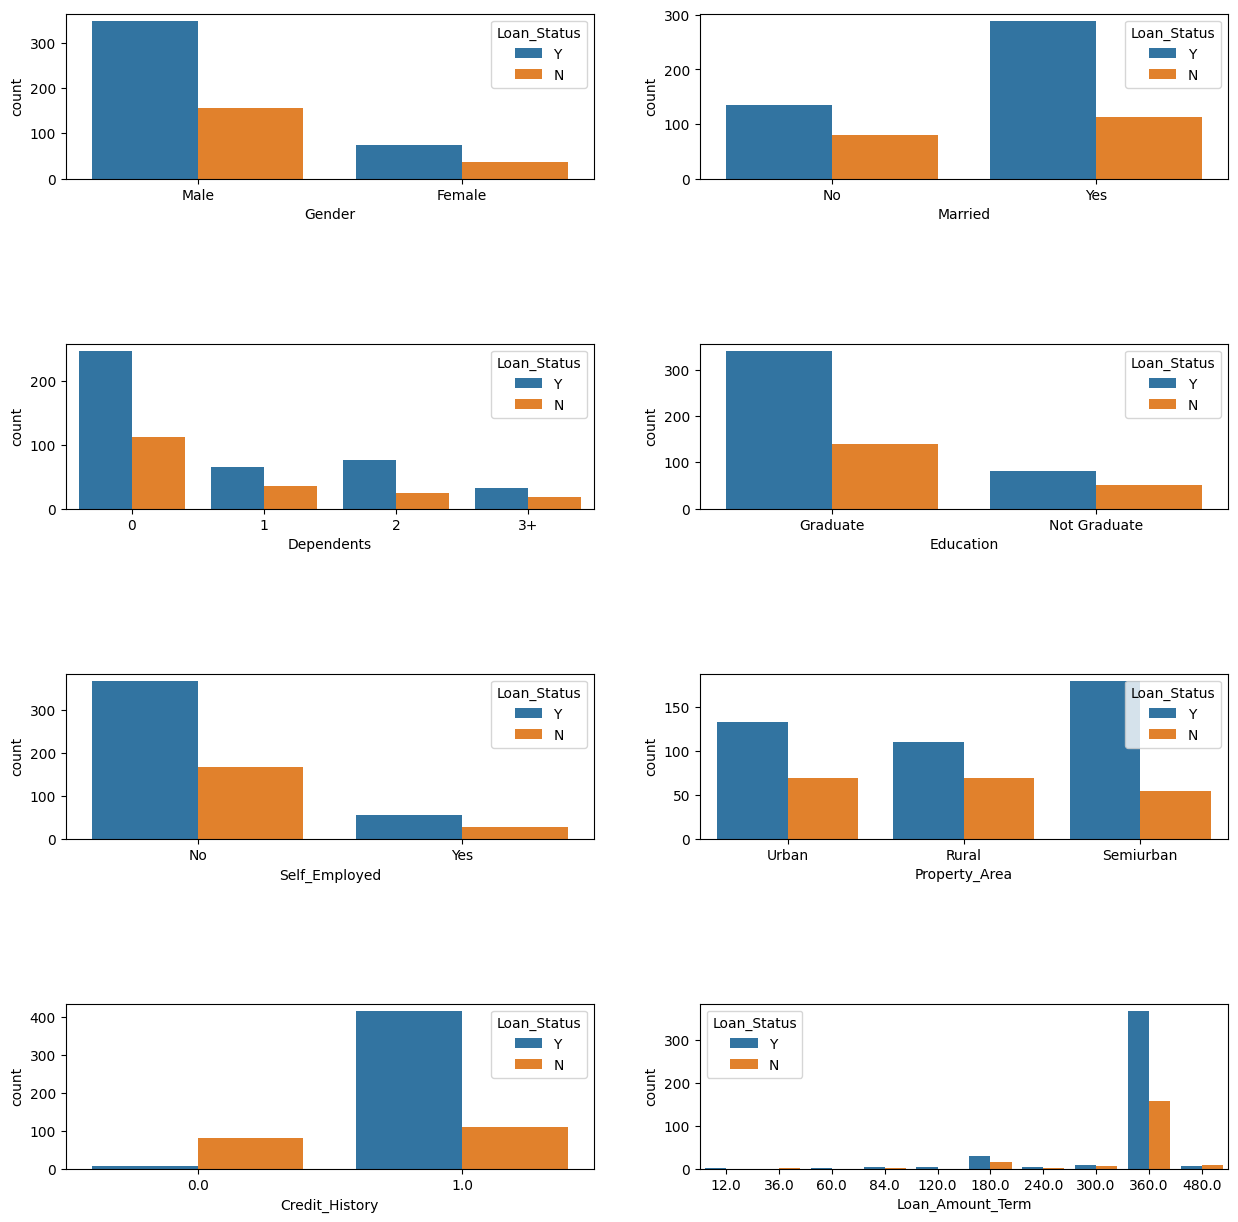

In [41]:
# Analysing loan status with counplot based on each categorical column and their options
fig,axes = plt.subplots(4,2,figsize=(15,15))
for idx,cat_col in enumerate(categorical_columns):
    row,col = idx//2,idx%2
    sns.countplot(x=cat_col,data=df.drop(columns='Loan_ID'),hue='Loan_Status',ax=axes[row,col])
plt.subplots_adjust(hspace=1)

       ApplicantIncome  CoapplicantIncome  LoanAmount
count       614.000000         614.000000  614.000000
mean       5403.459283        1621.245798  146.412162
std        6109.041673        2926.248369   84.037468
min         150.000000           0.000000    9.000000
25%        2877.500000           0.000000  100.250000
50%        3812.500000        1188.500000  129.000000
75%        5795.000000        2297.250000  164.750000
max       81000.000000       41667.000000  700.000000


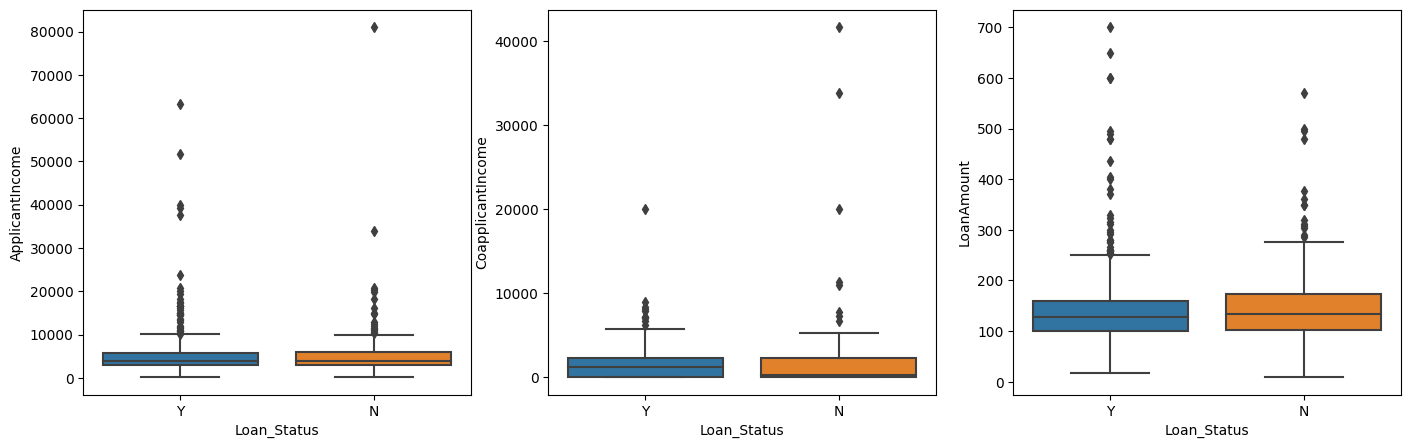

In [42]:
# Analysing loan status with box based on each numerical column and their values
fig,axes = plt.subplots(1,3,figsize=(17,5))
for idx,cat_col in enumerate(numerical_columns):
    sns.boxplot(y=cat_col,data=df.drop(columns='Loan_ID'),x='Loan_Status',ax=axes[idx])

print(df[numerical_columns].describe())
plt.subplots_adjust(hspace=1)

In [43]:
#Convert categorical column`s datatypes in order to apply feature selection 
df['Gender'] = df['Gender'].replace('Male',0).replace('Female',1)
df['Married'] = df['Married'].replace('No',False).replace('Yes',True)
df['Dependents'] = df['Dependents'].replace('0',0).replace('1',1).replace('2',2).replace('3+',3)
df['Education'] = df['Education'].replace('Not Graduate',0).replace('Graduate',1)
df['Self_Employed'] = df['Self_Employed'].replace('No',False).replace('Yes',True)
df['Property_Area'] = df['Property_Area'].replace('Urban',0).replace('Rural',1).replace('Semiurban',2)
df['Loan_Status'] = df['Loan_Status'].replace('N',0).replace('Y',1)



In [44]:
#Feature cross with applicant income and coapplicant income to meausure how much applicant can pay if need be
df['Income_Sum'] = df['ApplicantIncome'] + df['CoapplicantIncome']


In [45]:
# Feature selection using chi2 function in order to get more relevant features
X = df.drop(['Loan_ID', 'Loan_Status'], axis=1)
y = df['Loan_Status']


selector = SelectKBest(score_func=chi2, k=8)  
X_selected = selector.fit_transform(X, y)

selected_indices = selector.get_support(indices=True)
selected_features = X.columns[selected_indices]


print("Selected Features:")
print(selected_features)

Selected Features:
Index(['Married', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Income_Sum'],
      dtype='object')


In [46]:
#Picking our classifier and trying to imptove the accuracy
X_train, X_test, y_train, y_test = train_test_split(X_selected,y,test_size=0.2,random_state=42)

RFCmodel = RandomForestClassifier()
RFCmodel.fit(X_train,y_train)
rfc_pred = RFCmodel.predict(X_test)
rfc_acc = accuracy_score(rfc_pred, y_test)
print ("Random Forest Test accuracy: {:.2f}%".format(rfc_acc*100))

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

improved_model = RandomForestClassifier()


improved_model.fit(X_train_scaled, y_train)

y_pred_improved = improved_model.predict(X_test_scaled)
improved_model_accuracy = accuracy_score(y_test, y_pred_improved)
print("Improved Model Accuracy:", improved_model_accuracy)


Random Forest Test accuracy: 79.67%
Improved Model Accuracy: 0.7886178861788617


In [47]:
# Define the parameter grid for the grid search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}


rf = improved_model

# Perform grid search using cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best model and its hyperparameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Evaluate the best model on the testing data
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Best Model Accuracy:", accuracy)
print("Best Model Hyperparameters:", best_params)

Best Model Accuracy: 0.7967479674796748
Best Model Hyperparameters: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}


In [54]:
#Model evaluation  with cross validation

cv_scores = cross_val_score(best_model, X_selected, y, cv=5)
mean_cv_score = cv_scores.mean()


print("Cross-Validation Scores:", cv_scores)
print("Mean Cross-Validation Score:", mean_cv_score)

# Calculate additional evaluation metrics
y_pred_train = best_model.predict(X_selected)
mae = mean_absolute_error(y, y_pred_train)
rmse = np.sqrt(mean_squared_error(y, y_pred_train))

print("Mean Absolute Error:", mae)
print("Root Mean Square Error:", rmse)

Cross-Validation Scores: [0.80487805 0.77235772 0.78861789 0.83739837 0.81967213]
Mean Cross-Validation Score: 0.8045848327335733
Mean Absolute Error: 0.1775244299674267
Root Mean Square Error: 0.4213364806985347


In [49]:
#Save improved model to a file 
file = 'ML_Model1.pkl'
with open(file, 'wb') as f:
    pickle.dump(best_model, f)

In [50]:
with open(file, 'rb') as f:
    k = pickle.load(f)

In [51]:

selected_features


Index(['Married', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Income_Sum'],
      dtype='object')

In [31]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Income_Sum
0,LP001002,0,False,0,1,False,5849,0.0,146.412162,360.0,1.0,0,True,5849.0
1,LP001003,0,True,1,1,False,4583,1508.0,128.000000,360.0,1.0,1,False,6091.0
2,LP001005,0,True,0,1,True,3000,0.0,66.000000,360.0,1.0,0,True,3000.0
3,LP001006,0,True,0,0,False,2583,2358.0,120.000000,360.0,1.0,0,True,4941.0
4,LP001008,0,False,0,1,False,6000,0.0,141.000000,360.0,1.0,0,True,6000.0


In [52]:
#Entering only
cy = k.predict([[True,	5849,	2600, 1911,	360.0, 0.0,	2,	5849]])
print(cy)

[0]
